In [1]:
import pandas as pd
import numpy as np
import umap
import hdbscan

import warnings
warnings.filterwarnings("ignore")



C:\Users\F1302\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("importation-635-focus-AI.csv", sep=";")
df.columns

Index(['post_id', 'pf_post_id', 'post_date', 'account_id', 'pf_account_id',
       'chunk_id', 'document_id', 'document_text', 'lemmatized_text',
       'sentences', 'post_url', 'sentiment', 'topic', 'label', 'x', 'y',
       'proba', 'screen_name', 'description', 'followers', 'followings',
       'user_posts', 'post_engagements', 'post_reactions', 'post_comments',
       'post_shares', 'post_views', 'post_quotes', 'citations', 'repartages',
       'sentiment_score'],
      dtype='object')

# Pipeline NLP - Spacy

In [3]:
%%time
import re
from tqdm import tqdm
import emoji
import spacy
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def load_spacy_model(model: str) -> spacy.language.Language:
    """
    Load a spaCy model with optional configurations.

    Args:
        model : str
            Name of the spaCy model to load.

    Returns:
        nlp : spacy.language.Language
            Loaded spaCy language processing pipeline.

    """
    if torch.cuda.is_available():
        spacy.prefer_gpu()

    nlp = spacy.load(model)

    return nlp

def clean_text(text: str) -> str:
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()  # Remove leading/trailing spaces
    return text

def spacy_NER(nlp, df: pd.DataFrame, col_text: str, entities_to_keep: list = ['PERSON','ORG', 'LOC'], explode: bool = True, batch_size : int = 1000, n_process: int =8) -> pd.DataFrame:
    """
    Spacy implementation of NER.
    To define entities type to keep, call get_labels(nlp, pipe_step="ner", explanations=False)
    explode = False means it returns 1 list of entities per document
    explode = True means it returns 1 entity per row

    Args:
        nlp : spacy.language.Language
            The spaCy language processing pipeline.
        df : pd.DataFrame
            DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        entities_to_keep : list, optional
            List of entity types to keep. Default is ['PERSON','ORG', 'LOC'].
        batch_size : int, optional
            Batch sizes
        n_process : int, optional
            Number of processes

    Returns:
        pd.DataFrame
            DataFrame containing the NER information.

    Description:
        This function performs Named Entity Recognition (NER) using spaCy on a DataFrame with text data. It extracts entities of the specified types
        and stores the NER information in separate columns.
    """
    df[col_text] = df[col_text].apply(clean_text)
    l_text = df[col_text].tolist()
    all_records = []
    for doc in tqdm(nlp.pipe(l_text, batch_size=batch_size, n_process=n_process), total= len(l_text), desc = "NLP Process"):
        NER_type = []
        NER_text = []

        if len(entities_to_keep)>0:
            for ent in doc.ents:
                if ent.label_ in entities_to_keep:
                    NER_type.append(ent.label_)
                    NER_text.append(ent.text)
        else:
            for ent in doc.ents:
                NER_type.append(ent.label_)
                NER_text.append(ent.text)
        record = (NER_type, NER_text)
        all_records.append(record)

    df[['NER_type', 'NER_text']] = pd.DataFrame(all_records, index=df.index)

    return df


def generate_wordcloud(df: pd.DataFrame,
                       col_word: str,
                       col_metric: str,
                       width: int = 1500,
                       height: int = 750,
                       dpi: int = 72,
                       background_color: str = 'white',
                       show: bool = False) -> WordCloud:
    """
    Generate a word cloud from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing word frequency data.
        col_word (str): Column name containing words.
        col_metric (str): Column name containing frequency metrics for each word.
        width (int, optional): Width of the word cloud image. Defaults to 3000.
        height (int, optional): Height of the word cloud image. Defaults to 1500.
        dpi (int, optional): Dots per inch for image resolution. Defaults to 300.
        background_color (str, optional): Background color of the word cloud image. Defaults to 'white'.
        show (bool, optional): Whether to display the word cloud image. Defaults to False.

    Returns:
        WordCloud: WordCloud object representing the generated word cloud.
    """

    top_n_words={row[col_word]:row[col_metric] for i,row in df.iterrows()}
    # top_n_words = dict(zip(df.col_word, df.col_metric)) ## plus optmisé

    # Generate a wordcloud of the top n words
    wordcloud = WordCloud(width=width, height=height, background_color=background_color, prefer_horizontal=1).generate_from_frequencies(top_n_words)
    if show :
        plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    return wordcloud



# on charge notre modèle
nlp = load_spacy_model("en_core_web_lg")

# on affiche les labels disponibles pour le modèle chargé et la fonction linguistique visée
pipe_details = nlp.get_pipe("ner")
labels=list(pipe_details.labels)
print(labels)

['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']
CPU times: total: 9.36 s
Wall time: 18.2 s


In [4]:
# %%time
# # Ici on sélectionne le type d'entités nommées à détecter
# entity_labels = labels

# # on utilise la fonction de détection d'entitées nommées
# df = spacy_NER(nlp, df, "sentences", entities_to_keep = [], batch_size = 1024, n_process = 1)

# # on crée un nouveau dataframe où 1 ligne = 1 entitée
# df_entities = df.copy()
# df_entities = df_entities[df_entities['NER_type'].apply(lambda x: len(x) > 0)]
# df_entities = df_entities.explode(['NER_type', 'NER_text'])

# # on affiche les entitées les plus fréquemment citées
# for NER_type in labels:
#   df_top_entities = (
#                       df_entities[df_entities['NER_type']== NER_type].groupby(['NER_text', 'NER_type'])
#                       .agg({"post_id":'nunique'})
#                       .sort_values(by="post_id", ascending=False)
#                       .reset_index()
#                     )
#   print(NER_type)
#   generate_wordcloud(df_top_entities.head(50), "NER_text", "post_id", show = True)
#   print('\n'*3)

# Lemmatisation


In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS as sw


In [5]:
%%time 
def lemmatization(nlp, df: pd.DataFrame, col_text: str, col_lemma: str, pos_to_keep: list = [], stopwords: list = [], batch_size: int = 512, n_process: int = 1, join_list: bool = False) -> pd.DataFrame:
    """
    Perform natural language processing tasks using spaCy : tokenization, PoS Tagging and lemmatization

    Args:
        nlp : spacy.Language
            The spaCy language model.
        df : pandas.DataFrame
            The DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        col_lemma : str
            The name of the column to store the lemmatized text data.
        pos_to_keep : list
            A list of part-of-speech tags to keep during lemmatization.
        stopwords : list
            A list of stopwords to remove during processing.
        batch_size : int, optional
            The batch size for spaCy processing. Default is 100.
        n_process : int, optional
            The number of processes for parallel processing. Default is 1.
        join_list : bool, optional
            Whether to join the lemmas into a single string. Default is False.

    Returns:
        pandas.DataFrame
            The DataFrame with processed text data.

    """
    all_lemmas=[]
    text=list(df[col_text].astype('unicode').values)

    for doc in tqdm(nlp.pipe(text, batch_size=batch_size, n_process=n_process), total= len(text), desc = "NLP Process"):

# garde uniquement les mots pertinents, flitre
        if len(pos_to_keep)>0 and len(stopwords)>0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep)>0 and len(stopwords) < 1:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep) < 1 and len(stopwords) > 0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords ] ##### Be carful on CARDINAL label
        else :
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space)]

        all_lemmas.append(lemmas_list)

    if join_list:
        df[col_lemma]=[' '.join(map(str, l)) for l in all_lemmas]
    else:
        df[col_lemma]=all_lemmas

    return df

# toujours à l'aide de notre modèle spacy, on lemmatise le texte en ne conservant que certains PoS tags

df = lemmatization(nlp, df, "sentences", "lemmatized_text", pos_to_keep=[], batch_size = 512, n_process = 1, join_list = True)
print(df["lemmatized_text"])

NLP Process: 100%|██████████| 1853/1853 [00:10<00:00, 171.61it/s]

0       i just sign the @authorsguild 's open letter t...
1       although trump have no intention it can signif...
2       when a study support the prior of reviewer the...
3       be this not suppose to be a deep research"-bas...
4       i decide to trial use an ai tool to help with ...
                              ...                        
1848    science mean be able to change your mind in li...
1849    the 2024 1 version of the rating u sapiens be ...
1850    this paper be retract for not report the prima...
1851    this will sound silly but i swear i read and a...
1852    how to keep an open mind 1 think like a scient...
Name: lemmatized_text, Length: 1853, dtype: object
CPU times: total: 10.7 s
Wall time: 10.8 s


# Sampling


In [6]:
df_sample = df[~df["sentences"].duplicated()]
print(df_sample.shape)
df_not_sample =  df[~df['post_id'].isin(df_sample['post_id'])]
df_not_sample.shape

(1214, 31)


(639, 31)

# Topic Modeling - Etape n°1 - Vectorisation

On va transformer nos textes en vecteurs ("embeddings") à l'aide d'un modèle pré-entrainé de type "SentenceTransformer".


In [7]:
%%time
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")  

# Encode the texts
sample_embeddings = model.encode(list(df_sample['sentences']))
not_sample_embeddings = model.encode(list(df_not_sample['sentences']))
sample_embeddings.shape


CPU times: total: 12min 42s
Wall time: 3min 26s


(1214, 768)

In [8]:
%%time
# Fast and efficient model (all-MiniLM-L6-v2)
model_fast = SentenceTransformer("all-MiniLM-L6-v2")
# Encode the texts
sample_embeddings_fast = model_fast.encode(list(df_sample['sentences']))
not_sample_embeddings_fast = model_fast.encode(list(df_not_sample['sentences']))
print(f"Fast model embeddings shape: {sample_embeddings_fast.shape}")


# Basic/slower model for comparison (TF-IDF based)
model_basic = SentenceTransformer("average_word_embeddings_glove.6B.300d")
# Encode the texts
sample_embeddings_basic = model_basic.encode(list(df_sample['sentences']))
not_sample_embeddings_basic = model_basic.encode(list(df_not_sample['sentences']))
print(f"Basic model embeddings shape: {sample_embeddings_basic.shape}")

Fast model embeddings shape: (1214, 384)
Basic model embeddings shape: (1214, 300)
CPU times: total: 1min 51s
Wall time: 30.1 s


# Etape n°2 - Réduction de dimensions
Chaque texte est désormais représenté par un vecteur en 364 dimensions. On va effectuer une réduction de dimensions pour

*   facilement représenter le résultat en 2 ou 3 dimensions
*   limiter les calculs
* s'intéresser aux dimensions les plus "significatives"


## Model_quality

Reduced embeddings shape: (1214, 2)


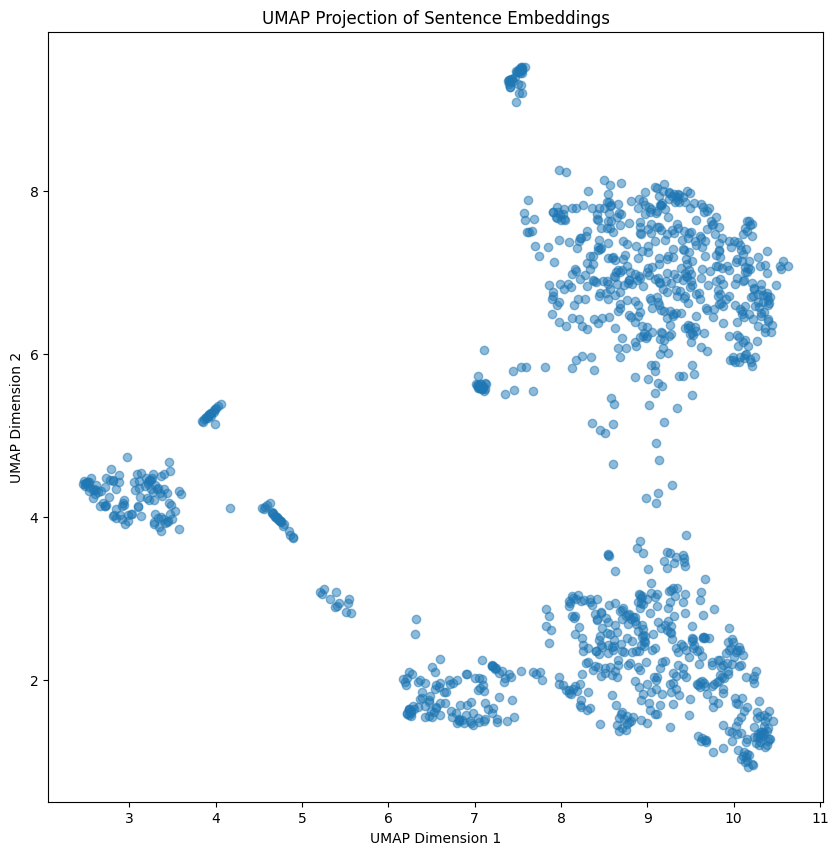

CPU times: total: 14.2 s
Wall time: 13.7 s


In [9]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

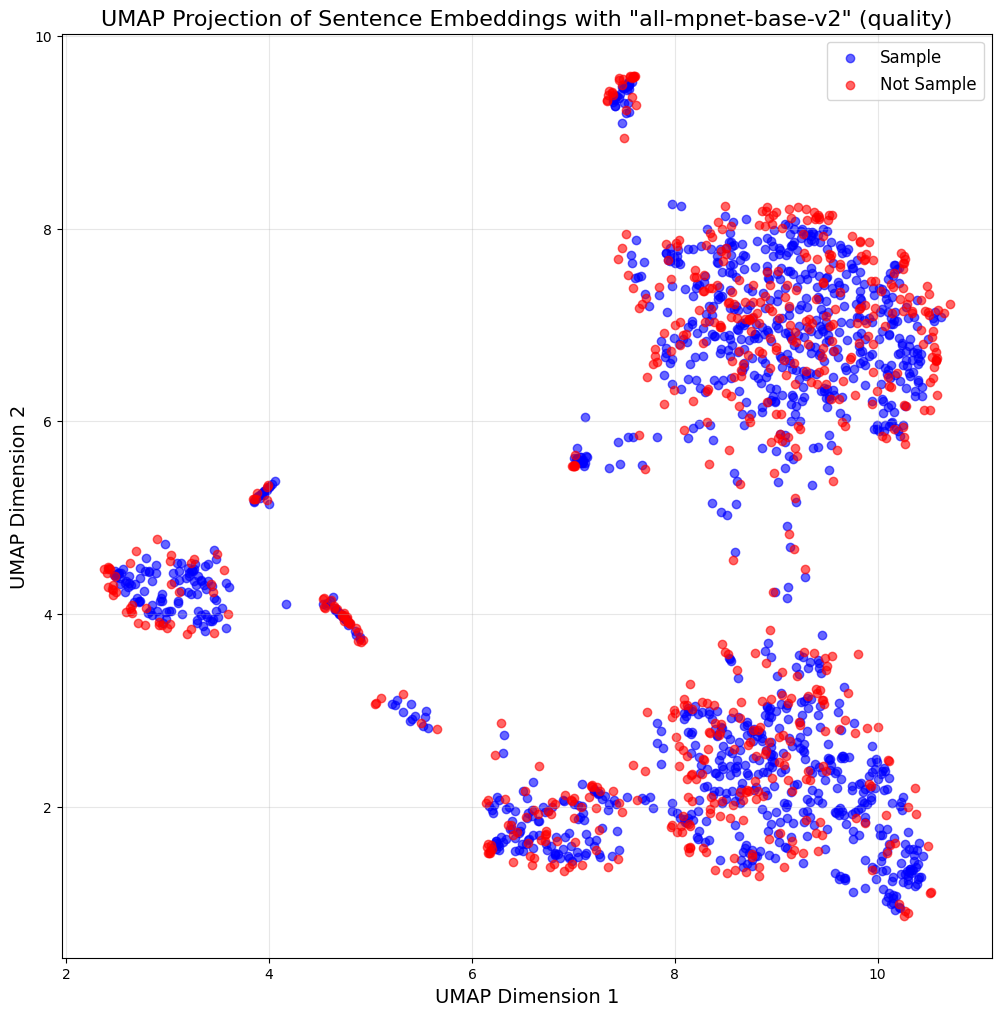

Number of sample points: 1214
Number of not_sample points: 639


In [10]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings with "all-mpnet-base-v2" (quality)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")


## Model_fast

Reduced embeddings shape: (1214, 2)


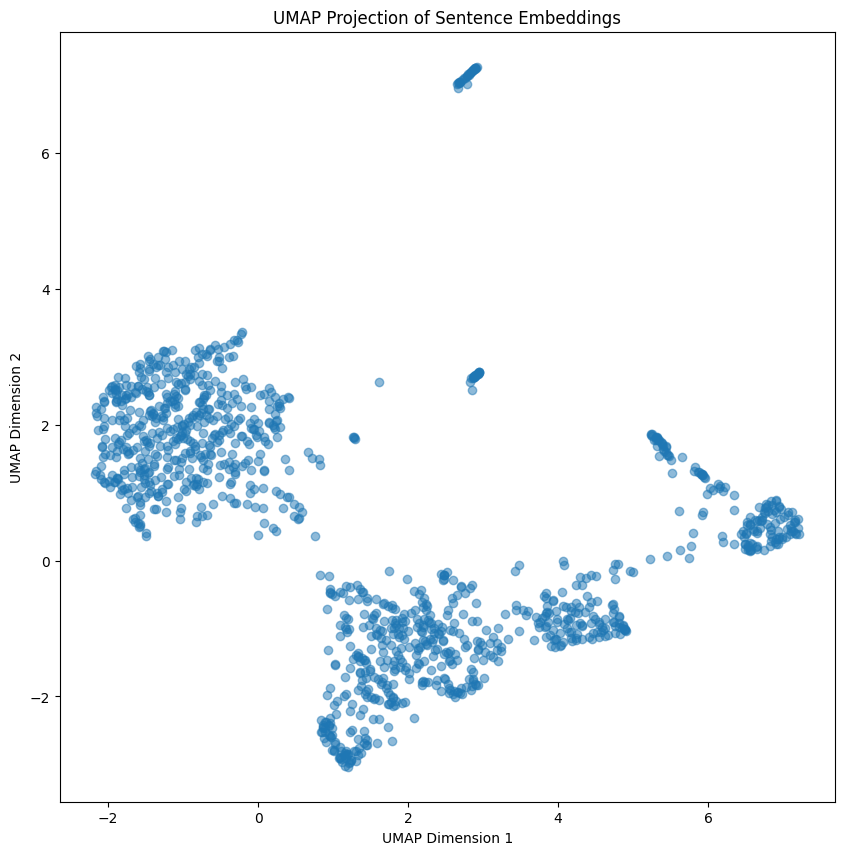

CPU times: total: 5.02 s
Wall time: 4.37 s


In [11]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_fast)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_fast)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

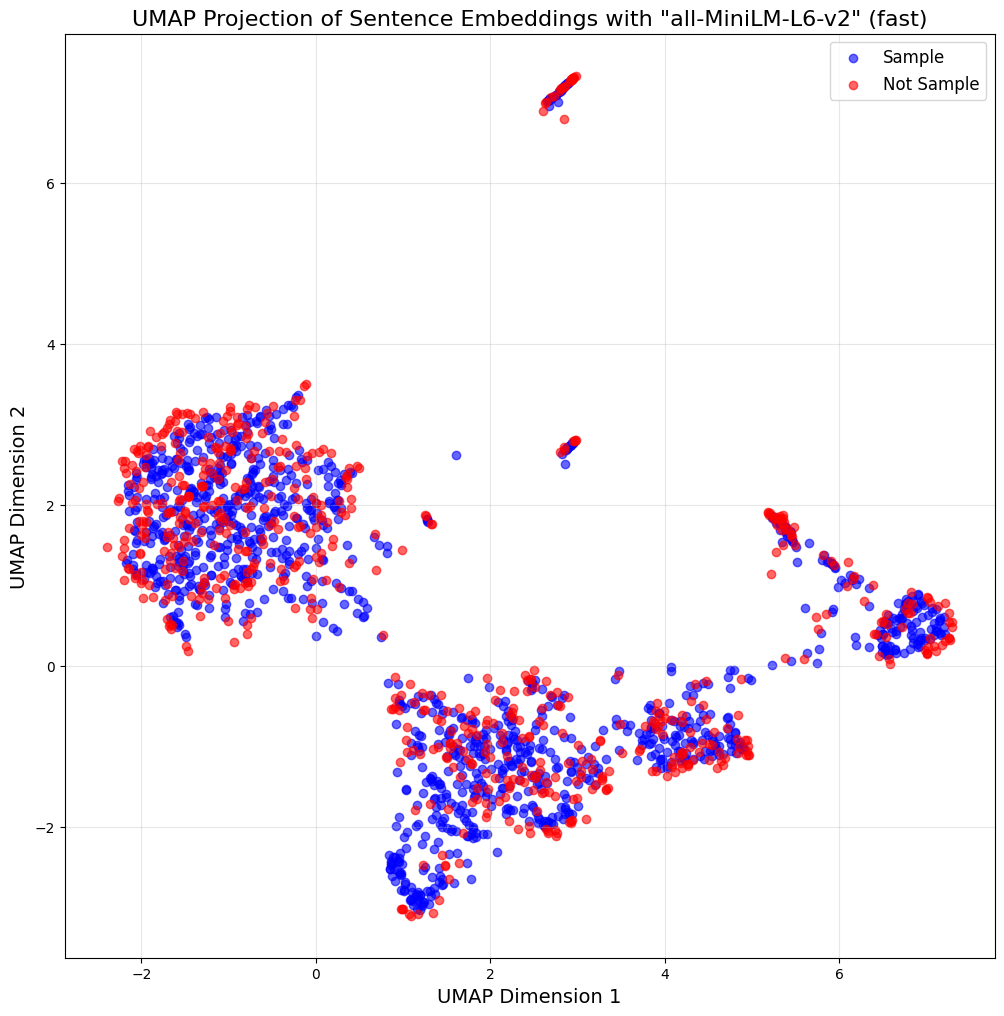

Number of sample points: 1214
Number of not_sample points: 639


In [ ]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_fast)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings with "all-MiniLM-L6-v2" (fast )', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")


## Model_simple

Reduced embeddings shape: (1214, 2)


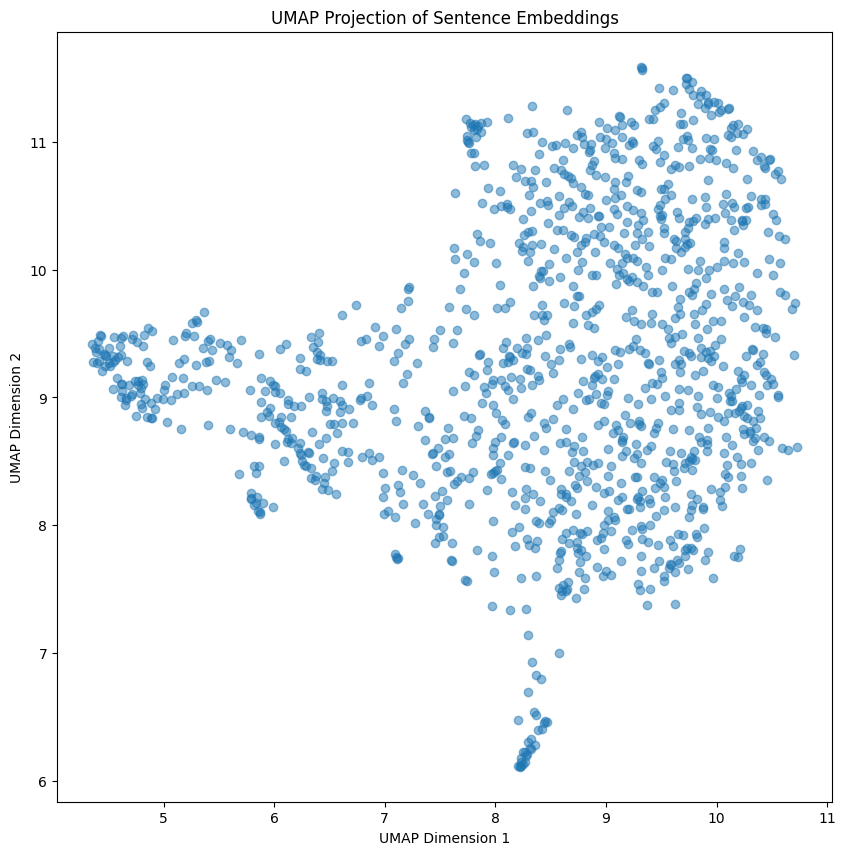

In [ ]:
parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_basic)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_basic)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

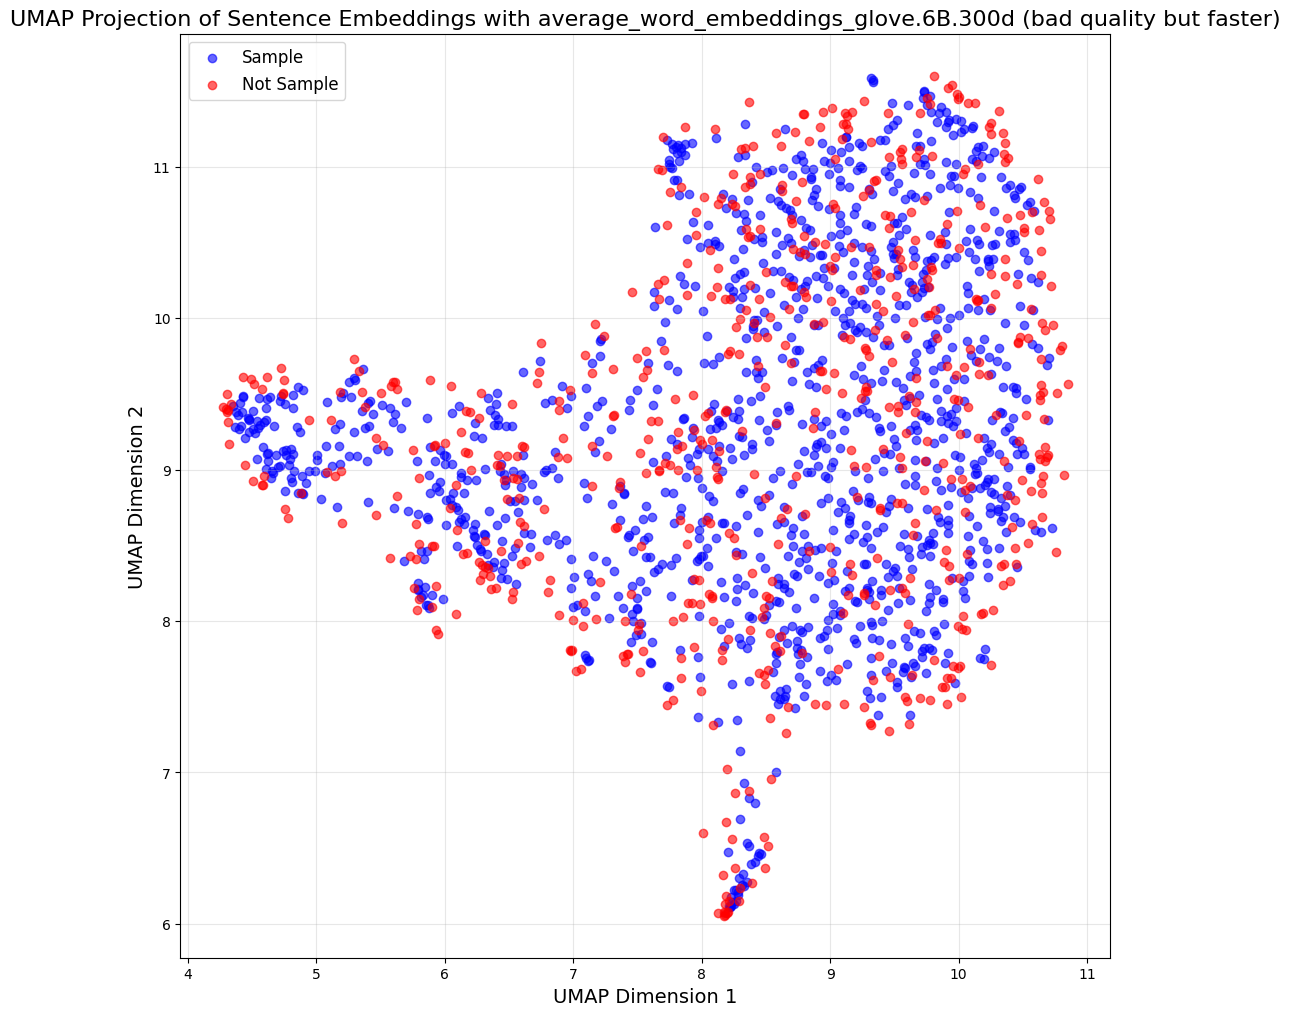

Number of sample points: 1214
Number of not_sample points: 639


In [14]:
# Transform not_sample embeddings using the same reducer
not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_basic)

# Add the coordinates to the not_sample dataframe
df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# Add source column to distinguish between datasets
df_sample['source'] = 'sample'
df_not_sample['source'] = 'not_sample'

# Concatenate the dataframes
df_concat = pd.concat([df_sample, df_not_sample])

# Create the plot using matplotlib
plt.figure(figsize=(12, 12))

# Plot sample points
sample_data = df_concat[df_concat['source'] == 'sample']
plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# Plot not_sample points
not_sample_data = df_concat[df_concat['source'] == 'not_sample']
plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# Add labels and legend
plt.title('UMAP Projection of Sentence Embeddings with average_word_embeddings_glove.6B.300d (bad quality but faster)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.show()

# Print some statistics
print(f"Number of sample points: {len(sample_data)}")
print(f"Number of not_sample points: {len(not_sample_data)}")
